# Train데이터 불러오기

각 년도별 DataFrame을 리스트에 append합니다.

리스트 인덱스별로

0: 2017년도 데이터   

1: 2018년도 데이터 

2: 2019년도 데이터 

3: 202년도 데이터 

입니다

In [1]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.seed = 42
DATA_PATH = "../data_0115/"

warnings.filterwarnings(action='ignore')
PATH_2017 = DATA_PATH + "train/KNOW_2017.csv"
PATH_2018 = DATA_PATH + "train/KNOW_2018.csv"
PATH_2019 = DATA_PATH + "train/KNOW_2019.csv"
PATH_2020 = DATA_PATH + "train/KNOW_2020.csv"

paths = [PATH_2017, PATH_2018, PATH_2019, PATH_2020]

know_train = [pd.read_csv(path) for path in paths]

In [2]:
know_train[0].head() # 2017년도 샘플

,idx,aq1_1,aq1_2,aq2_1,aq2_2,aq3_1,aq3_2,aq4_1,aq4_2,aq5_1,...,text_response,sim_job,bef_job,able_job,major,description,bq6_mark,bq12_2_mark,bq12_3_mark,bq12_4_mark
0,0,3,3,3,3,3,3,4,4,3,...,자동차도장기능사 실무교육 생산 설비 자동화 없다,없다,없다,건설현장 노무직,실업,도장원(도장기조작원),0,0,0,0
1,1,4,5,4,5,3,4,3,4,3,...,건축전기설비기술사 건설 수주 드라이버 가위,없다,0,0,건축공학,건축설비 기술자,0,0,0,0
2,2,3,4,3,4,3,4,5,6,4,...,건축전기설비기술사 신축 건설 경기 건축 설계 오토캐드 파이프 보일러,없다,0,0,건축공학,건축설비 기술자,0,0,0,0
3,3,3,3,3,3,3,5,4,5,4,...,지적기사 측량 정보통신기술 교육 무량 감소 자동화 토탈 스테이션,지적기사,무,지적공무원,환경학과,지적 및 측량기술자,0,0,0,0
4,4,4,5,3,4,3,4,4,5,3,...,건축전기설비기술사 부동산 거품 건축 경기도 덩달아 불황 캐드 엑셀 건축 도면,없다,0,0,건축공학,건축설비 기술자,0,0,0,0


# 전처리 

`data_0115`는 이미 전처리된 데이터

## 라벨 인코딩

숫자로 변환할 수 있는 컬럼은 라벨 인코딩을 사용하지 않았습니다.

string이나 object컬럼은 라벨인코더를 이용해 변환하였으며 추후 test셋에 사용해야하기 때문에 년도별, 컬럼별로 dictionary를 이용해 저장하였습니다

In [3]:
from sklearn.preprocessing import LabelEncoder
years = ['2017', '2018', '2019', '2020']

year_encoder = {}

for year, df in zip(years, know_train):
    print(year)
    encoders = {}
    
    for col in df.columns:
        if col == 'idx':
            print("HEHE")
            continue
        
        try:
            df[col] = df[col].map(int)
        except:
            encoder = LabelEncoder()
            df[col] = df[col].map(str)
            df[col] = encoder.fit_transform(df[col])
            encoders[col] = encoder
            
            
    year_encoder[year] = encoders

2017
HEHE
2018
HEHE
2019
HEHE
2020
HEHE


In [4]:
for i in range(4):
    print(f"{2017+i}: {know_train[i].shape}")

2017: (9486, 155)
2018: (9072, 130)
2019: (8555, 152)
2020: (8122, 185)


# X, y 구분 및 모델 학습

이번 대회에서 맞춰야 할 값은 knowcode입니다.

ID와 knowcode를 제외한 나머지 feature를 X, knowcode를 정답 y로 두어 모델을 학습하였습니다.

베이스라인에서는 의사결정나무와 랜덤포레스트를 선정하였습니다

df.drop(['idx','knowcode'], axis=1)

In [5]:
train_data = {}
for year, df in zip(years, know_train):
    train_data[year] = {'X': df.drop(['idx','knowcode','text_response','description'], axis=1),
                        'y': df['knowcode']} 

In [6]:
train_data['2017']

{'X':       aq1_1  aq1_2  aq2_1  aq2_2  aq3_1  aq3_2  aq4_1  aq4_2  aq5_1  aq5_2  \
 0         3      3      3      3      3      3      4      4      3      4   
 1         4      5      4      5      3      4      3      4      3      4   
 2         3      4      3      4      3      4      5      6      4      5   
 3         3      3      3      3      3      5      4      5      4      6   
 4         4      5      3      4      3      4      4      5      3      4   
 ...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
 9481      3      5      2      4      3      3      2      2      2      3   
 9482      5      5      5      5      5      5      3      4      4      5   
 9483      3      3      4      6      3      3      4      5      4      5   
 9484      3      5      3      5      4      5      3      4      3      5   
 9485      3      4      3      4      3      4      3      4      3      4   
 
       ...  bq41_2  bq41_3  sim_job  bef_job 

## SMOTE
class 불균형 완화

In [7]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

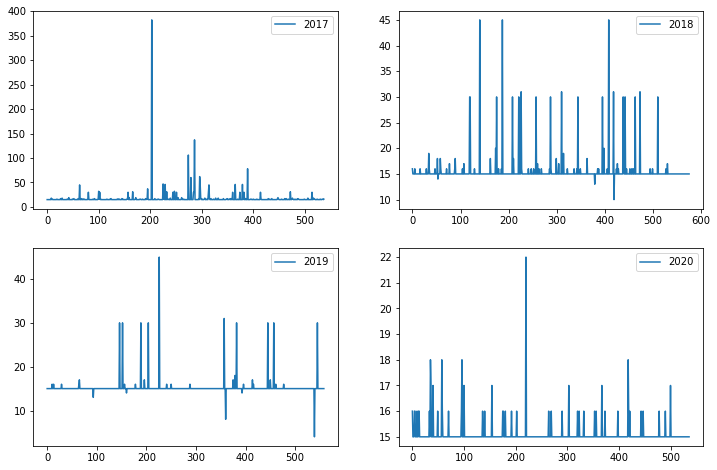

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for year in years:
    if year == '2017': r,c = 0,0
    elif year == '2018': r,c = 0,1
    elif year == '2019': r,c = 1,0
    elif year == '2020': r,c = 1,1
    
    d = train_data[year]['y'].value_counts(sort=False).tolist()
    axes[r, c].plot(d, label=f"{year}")
    axes[r, c].legend()

fig.show()

In [9]:
for year in years:
    print(year)
    print(f"X :{train_data[year]['X'].shape}, y: {train_data[year]['y'].shape}")

2017
X :(9486, 151), y: (9486,)
2018
X :(9072, 126), y: (9072,)
2019
X :(8555, 148), y: (8555,)
2020
X :(8122, 181), y: (8122,)


In [10]:
train_data[year]['X']

,saq1_1,saq1_2,saq2_1,saq2_2,saq3_1,saq3_2,saq4_1,saq4_2,saq5_1,saq5_2,...,bq28,bq29,bq30_1,bq30_2,bq30_3,major,bq6_mark,bq12_2_mark,bq12_3_mark,bq12_4_mark
0,4,4,4,4,4,5,4,5,3,3,...,1,40,4000,2600,0,9,1,0,0,0
1,5,6,5,6,4,5,4,5,4,5,...,1,40,4000,3000,0,166,0,0,0,0
2,3,4,3,4,3,4,3,5,3,5,...,1,48,4300,3000,0,161,0,0,0,0
3,4,5,2,3,3,3,4,5,3,4,...,1,40,3500,3300,0,368,0,0,0,0
4,5,6,4,5,3,5,4,4,4,6,...,1,40,5700,2700,0,22,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8117,4,6,3,5,3,3,1,0,5,5,...,1,40,5100,4000,0,890,0,0,0,0
8118,3,4,4,5,2,4,4,6,1,0,...,1,45,3100,2600,0,96,0,0,0,0
8119,5,6,3,4,3,4,4,5,5,7,...,1,40,8000,3000,0,114,1,0,0,0
8120,5,6,5,5,4,5,3,3,3,4,...,1,40,5700,3200,0,1069,0,0,0,0


In [11]:
train_data[year]['y']

0       304003
1       221401
2       815001
3       304003
4       140201
         ...  
8117    121105
8118     26102
8119     31301
8120    154105
8121     14201
Name: knowcode, Length: 8122, dtype: int64

In [12]:
for i, v in train_data[year]['y'].value_counts()[:5].items():
    print(i,v)

140101 22
25401 18
416203 18
240101 18
306903 18


In [13]:
train_data[year]['y'].value_counts().items()

In [14]:
# resampling with SMOTE
train_data_resampled = {}

sample_num_per_year = {
    '2017': 50, 
    '2018': 30,
    '2019': 30,
    '2020': 18
}

for year in years:
    print(f"{year} sampling")
    target_counts = train_data[year]['y'].value_counts()
    resample_dict = {}
    sample_num = sample_num_per_year[year]
    k_neighbors = 6
    for i, num in target_counts.items():
        resample_dict[i] = max(num, sample_num)
        if num < k_neighbors:
            k_neighbors = num-1
            print(f"minimum neighbor size {k_neighbors}")

    smote = SMOTE(sampling_strategy=resample_dict, random_state=RANDOM_STATE,
            k_neighbors=k_neighbors
        )
    X_resampled, y_resampled = smote.fit_resample(train_data[year]['X'], train_data[year]['y'])
    
    train_data_resampled[year] = {
        'X': X_resampled, 'y': y_resampled
    }
    print("done")

2017 sampling
done
2018 sampling
done
2019 sampling
minimum neighbor size 3
done
2020 sampling
done


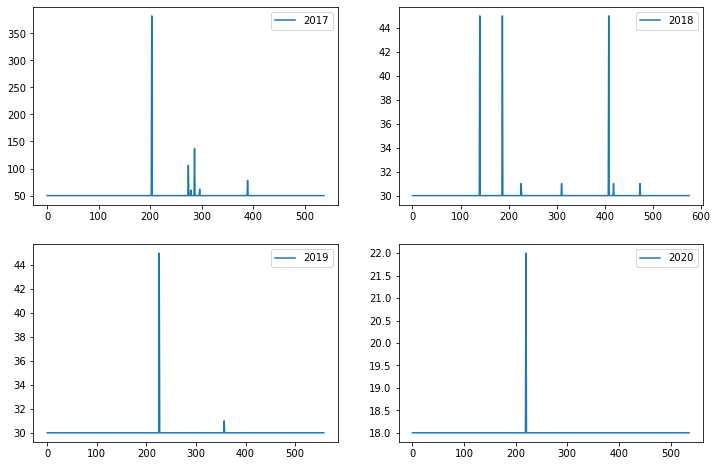

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for year in years:
    if year == '2017': r,c = 0,0
    elif year == '2018': r,c = 0,1
    elif year == '2019': r,c = 1,0
    elif year == '2020': r,c = 1,1
    
    d = train_data_resampled[year]['y'].value_counts(sort=False).tolist()
    axes[r, c].plot(d, label=f"{year}")
    axes[r, c].legend()

fig.show()

In [16]:
for year in years:
    print(year)
    print(
        f"X :{train_data[year]['X'].shape}, y: {train_data[year]['y'].shape} -> X :{train_data_resampled[year]['X'].shape}, y: {train_data_resampled[year]['y'].shape}")

2017
X :(9486, 151), y: (9486,) -> X :(27425, 151), y: (27425,)
2018
X :(9072, 126), y: (9072,) -> X :(17329, 126), y: (17329,)
2019
X :(8555, 148), y: (8555,) -> X :(16786, 148), y: (16786,)
2020
X :(8122, 181), y: (8122,) -> X :(9670, 181), y: (9670,)


In [17]:
train_data_resampled['2017']['X']

,aq1_1,aq1_2,aq2_1,aq2_2,aq3_1,aq3_2,aq4_1,aq4_2,aq5_1,aq5_2,...,bq41_2,bq41_3,sim_job,bef_job,able_job,major,bq6_mark,bq12_2_mark,bq12_3_mark,bq12_4_mark
0,3,3,3,3,3,3,4,4,3,4,...,0,2200,717,836,119,723,0,0,0,0
1,4,5,4,5,3,4,3,4,3,4,...,0,2400,717,9,5,33,0,0,0,0
2,3,4,3,4,3,4,5,6,4,5,...,0,2400,717,9,5,33,0,0,0,0
3,3,3,3,3,3,5,4,5,4,6,...,0,3500,991,469,1132,1446,0,0,0,0
4,4,5,3,4,3,4,4,5,3,4,...,0,2500,717,9,5,33,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27420,2,2,2,2,2,2,3,3,3,3,...,1476,0,717,1198,788,76,0,0,0,0
27421,2,2,1,1,1,1,2,2,1,1,...,1500,0,717,870,788,1,0,0,0,0
27422,2,2,2,2,2,2,2,2,2,2,...,293,723,717,836,677,1,0,0,0,0
27423,1,0,1,0,1,0,1,0,1,0,...,3045,0,710,836,788,958,0,0,0,0


# Extra Trees Classifier

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

et_models = {}

for year in tqdm(years):
    model = ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=8)
    model.fit(train_data_resampled[year]['X'].iloc[:, :], train_data_resampled[year]['y'])
    et_models[year] = model

100%|██████████| 4/4 [00:18<00:00,  4.74s/it]


## Testset 불러오기

마찬가지로 년도별로 DataFrame으로 불러온 후 리스트에 할당합니다.


In [19]:
TEST_PATH_2017 = DATA_PATH + "test/KNOW_2017_test.csv"
TEST_PATH_2018 = DATA_PATH + "test/KNOW_2018_test.csv"
TEST_PATH_2019 = DATA_PATH + "test/KNOW_2019_test.csv"
TEST_PATH_2020 = DATA_PATH + "test/KNOW_2020_test.csv"

TEST_PATHs = [TEST_PATH_2017, TEST_PATH_2018, TEST_PATH_2019, TEST_PATH_2020]

In [20]:
know_test = [pd.read_csv(path) for path in TEST_PATHs]
know_test[0].head() # 2017년도 test 샘플

,idx,aq1_1,aq1_2,aq2_1,aq2_2,aq3_1,aq3_2,aq4_1,aq4_2,aq5_1,...,bq41_3,text_response,sim_job,bef_job,able_job,major,bq6_mark,bq12_2_mark,bq12_3_mark,bq12_4_mark
0,0,3,4,2,2,3,3,1,0,3,...,2300,대체 업무 컴퓨터 없다,없다,없다,없다,비서학,1,0,0,0
1,1,5,5,3,5,5,5,5,5,4,...,2500,품질관리기사 실무교육 제조업 생각 때문 제품 검사 시스템 엑셀,없다,없다,없다,농화학,0,0,0,0
2,2,5,5,5,4,5,4,1,0,1,...,4000,기획력 현장경험 미디어 증가 오디션 편집 프로그램 홀로 방송 진행 장비 1인 미디어...,없다,없다,"광선, 홍보 담당자",신문방송,0,0,0,0
3,3,4,5,5,6,4,6,3,4,4,...,3000,선호 직업 컴퓨터 없다,없다,없다,없다,화학,1,0,0,0
4,4,5,6,4,5,4,5,1,0,1,...,2000,잡지 정보 뉴스 고갈 때문 유지 뉴스 원고 없다,편집기자,사진작가,리포터,광고홍보,1,0,0,0


In [21]:
know_test[1].head()

,idx,cq1,cq2,cq3,cq4,cq5,cq6,cq7,cq8,cq9,...,bef_job,able_job,major,bq22,bq23,bq24,bq6_mark,bq12_2_mark,bq12_3_mark,bq12_4_mark
0,9486,4,1,3,1,1,3,2,3,1,...,0,0,0,2.0,2.0,5,1,0,0,0
1,9487,5,4,5,5,5,5,3,3,3,...,0,같은 범주 안에 있는 직업.,커뮤니케이션 디자인 전공,1.0,1.0,1,0,0,0,0
2,9488,3,3,3,4,3,3,4,4,2,...,"카피라이터, 문화기획자",드라마 작가,국문학과,2.0,4.0,4,0,0,0,0
3,9489,4,4,4,4,2,3,3,4,4,...,없음,잡지사 편집 기획,극작학과,2.0,4.0,5,0,0,0,0
4,9490,5,2,3,2,4,4,4,4,3,...,0,0,실업,2.0,3.0,4,0,0,0,0


Train에 사용하였던 라벨인코더를 이용해서 카테고리를 정수로 변환합니다.

만약 Test변수가 Train 라벨인코더의 클래스에 없을경우 -1로 처리합니다

In [22]:
years = ['2017', '2018', '2019', '2020']

for year, df in zip(years, know_test):
    print(year)
    encoders = {}
    
    for col in df.columns:
        
        try:
            df[col] = df[col].map(int)
        except:
            encoder = year_encoder[year][col]
            df[col] = df[col].map(str)
            category_map = {category: idx for idx, category in enumerate(encoder.classes_)}
            df[col] = df[col].apply(lambda x: category_map[x] if x in category_map else -1) # train set에서 보지못한 카테고리변수 -1(UNK) 처리
            

2017
2018
2019
2020


### 데이터 처리 및 라벨인코딩 후 

In [23]:
know_train[0]['aq1_1'].value_counts()

3    3116
4    3007
2    1706
5    1072
1     585
Name: aq1_1, dtype: int64

In [24]:
know_test[0].head() # 2017년도 test 샘플

,idx,aq1_1,aq1_2,aq2_1,aq2_2,aq3_1,aq3_2,aq4_1,aq4_2,aq5_1,...,bq41_3,text_response,sim_job,bef_job,able_job,major,bq6_mark,bq12_2_mark,bq12_3_mark,bq12_4_mark
0,0,3,4,2,2,3,3,1,0,3,...,2300,-1,717,836,788,497,1,0,0,0
1,1,5,5,3,5,5,5,5,5,4,...,2500,-1,717,836,788,287,0,0,0,0
2,2,5,5,5,4,5,4,1,0,1,...,4000,-1,717,836,-1,705,0,0,0,0
3,3,4,5,5,6,4,6,3,4,4,...,3000,3847,717,836,788,1423,1,0,0,0
4,4,5,6,4,5,4,5,1,0,1,...,2000,-1,-1,-1,402,141,1,0,0,0


## 테스트셋 추출 및 학습

ID 값을 제외한 나머지 데이터를 이용하여 모델에 넣어 추론합니다.

In [25]:
test_data = {}
for year, df in zip(years, know_test):
    print(year)
    train_columns = train_data[year]['X'].columns
    # print(train_columns)
    test_data[year] =  {'X': df[train_columns]}

2017
2018
2019
2020


In [26]:
for year in years:
    print(year)
    print(f"train: {train_data_resampled[year]['X'].shape} test: {test_data[year]['X'].shape}")

2017
train: (27425, 151) test: (9486, 151)
2018
train: (17329, 126) test: (9069, 126)
2019
train: (16786, 148) test: (8554, 148)
2020
train: (9670, 181) test: (8122, 181)


### ET로 예측

In [27]:
et_predicts = [] 

for year in tqdm(years):
    pred = et_models[year].predict(test_data[year]['X'])
    et_predicts.extend(pred)

100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


# 제출

In [28]:
submission = pd.read_csv('../data_0103/sample_submission.csv') # sample submission 불러오기

In [29]:
submission['knowcode'] = et_predicts

submission.to_csv('../submission_files/et_smote_with_data0115.csv', index=False)